# Heart Disease Dataset

## Attribute information

- age
- sex
- chest pain type (4 values)
- resting blood pressure
- serum cholestoral in mg/dl
- fasting blood sugar > 120 mg/dl
- resting electrocardiographic results (values 0,1,2)
- maximum heart rate achieved
- exercise induced angina
- oldpeak = ST depression induced by exercise relative to rest
- the slope of the peak exercise ST segment
- number of major vessels (0-3) colored by flourosopy
- thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

from catboost import Pool, CatBoostClassifier

In [86]:
SEED = 42

In [87]:
data = pd.read_csv('heart.csv')

print(f'Shape of data: {data.shape}')

data.head()

Shape of data: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [89]:
cat_cols = ['sex', 'cp', 'fbs', 'exang', 'slope', 'ca', 'thal','restecg']
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

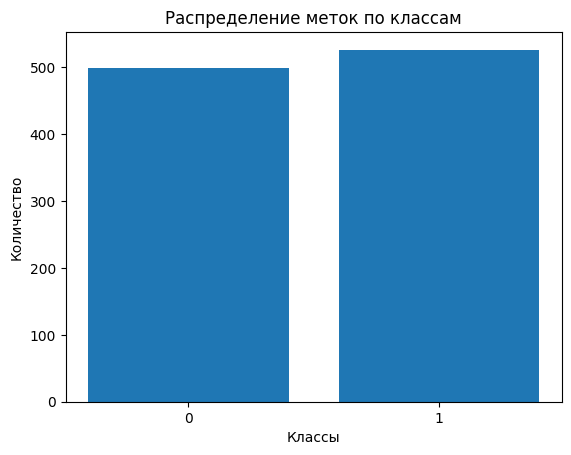

In [90]:
labels, counts = np.unique(data['target'], return_counts=True)

plt.bar(labels, counts, tick_label=labels)
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.title('Распределение меток по классам')
plt.show()

Данные хорошо сбалансированы по классам

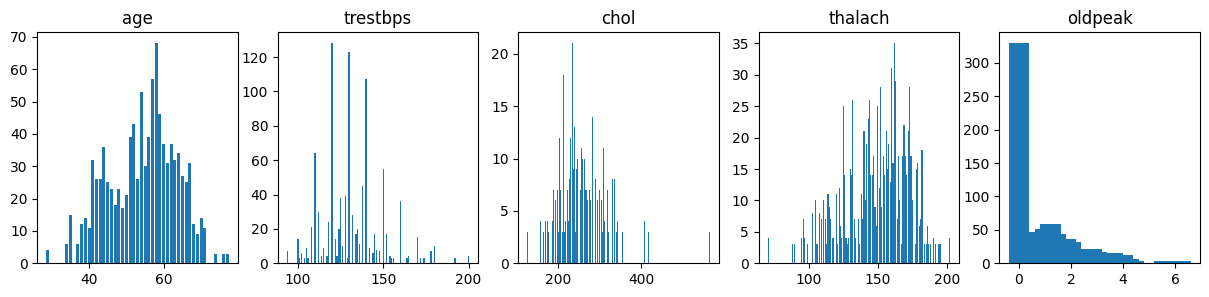

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,3))

for i, col in enumerate(num_cols):
    labels, counts = np.unique(data[col], return_counts=True)
    axes[i].set_title(col)
    axes[i].bar(labels, height=counts)

Количественные признаки распределены неплохо, стремятся к нормальному распределению. `oldpeak` имеет большинство 0 значений, что указывает, что большинство пациентов не имели ST депрессии. 

<BarContainer object of 26 artists>

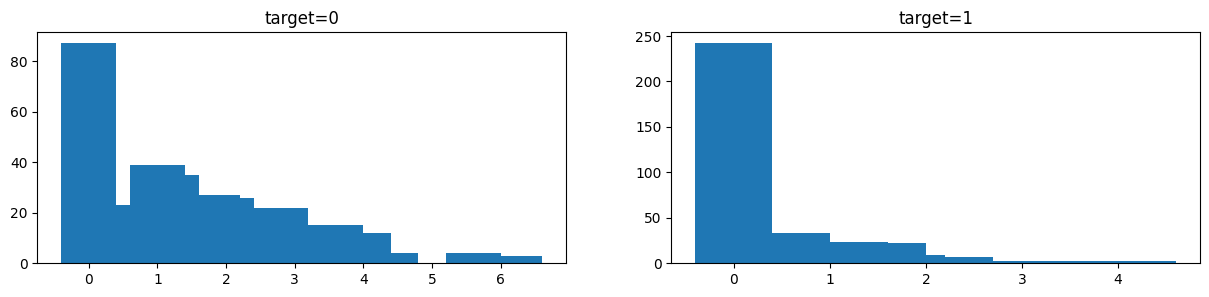

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,3))
labels, counts = np.unique(data[data.target==0][col], return_counts=True)
axes[0].set_title("target=0")
axes[0].bar(labels, height=counts)

labels, counts = np.unique(data[data.target==1][col], return_counts=True)
axes[1].set_title("target=1")
axes[1].bar(labels, height=counts)

Люди имеющие проблемы с сердцем в меньшей степени имеет ST депрессию.

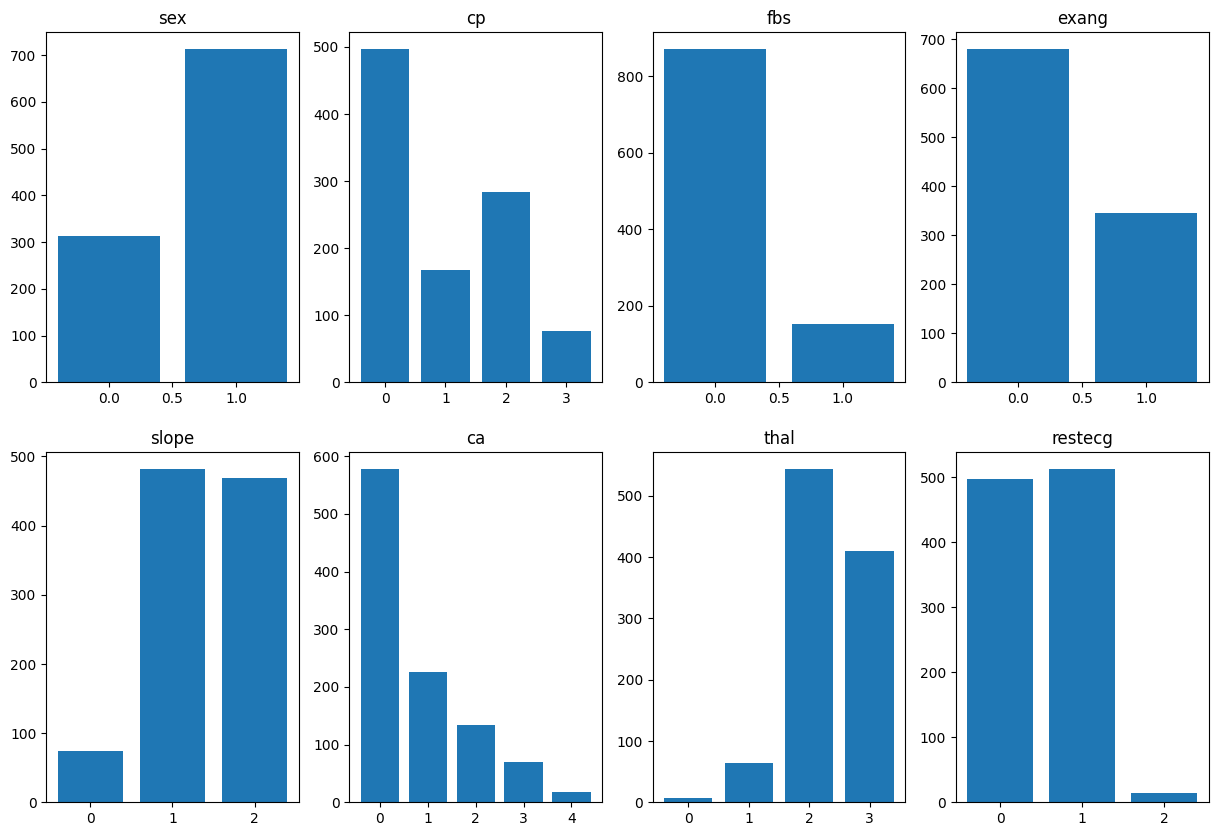

In [93]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for col, ax in zip(cat_cols, axes.ravel()):
    labels, counts = np.unique(data[col], return_counts=True)
    ax.set_title(col)
    ax.bar(labels, height=counts)

Смотря на распределение значений у качественных признаков можно понять, что при комбинации признаков можно точно выявить проблемы с сердцем. Я к тому что если бы распределения значений были одинаковы, то признак был бы неинформативен. Не смотря на то, что некоторых значений может быть мало в признаки, это может указывать на экстримальность отклонений, которая встречается редко. То есть если мы видим у человека нестандратные значения признаков, то после предсказания модели нужны дополнительные обследования для определения наличий проблем с серцем.

<AxesSubplot: >

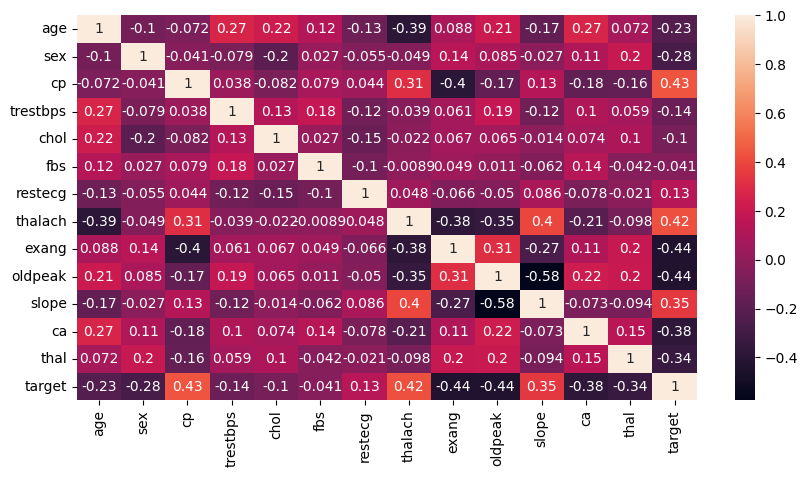

In [94]:
plt.figure(figsize=(10,5))
sns.heatmap(data.corr(), annot=True)

Мультиколлинеарность очень слабая, что супер! Признаки неплохо коррелируютс с таргетом, думаю при должной комбинации признаков корреляция будет высокая с таргетом.

In [95]:
X, y = data.drop(columns=['target'], axis=1), data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

## Pipeline

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", "passthrough", cat_cols)
    ]
)

pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("feature_selection", SelectFromModel(RandomForestClassifier(n_estimators=100, max_depth=3, random_state=SEED), max_features=int(len(cat_cols+num_cols)*0.7))),
        ("classifier", CatBoostClassifier(verbose=2, random_state=SEED, learning_rate=10e-3, thread_count=-1, depth=6, iterations=1500, eval_metric="F1"))
    ]
)

In [ ]:
pipeline.fit(X_train, y_train)

0:	learn: 0.8810872	total: 1.25ms	remaining: 1.88s
2:	learn: 0.8688525	total: 3.75ms	remaining: 1.87s
4:	learn: 0.8676640	total: 5.9ms	remaining: 1.76s
6:	learn: 0.8876147	total: 8.29ms	remaining: 1.77s
8:	learn: 0.8820160	total: 10.6ms	remaining: 1.76s
10:	learn: 0.8850575	total: 13ms	remaining: 1.76s
12:	learn: 0.8932715	total: 15.2ms	remaining: 1.74s
14:	learn: 0.8881200	total: 17.7ms	remaining: 1.75s
16:	learn: 0.8830275	total: 20.2ms	remaining: 1.76s
18:	learn: 0.8860759	total: 22.7ms	remaining: 1.77s
20:	learn: 0.8860759	total: 25.4ms	remaining: 1.78s
22:	learn: 0.8860759	total: 27.8ms	remaining: 1.78s
24:	learn: 0.8881200	total: 30.2ms	remaining: 1.78s
26:	learn: 0.8860759	total: 32.7ms	remaining: 1.79s
28:	learn: 0.8881200	total: 35.3ms	remaining: 1.79s
30:	learn: 0.8912037	total: 38.2ms	remaining: 1.81s
32:	learn: 0.8963912	total: 41.2ms	remaining: 1.83s
34:	learn: 0.8963912	total: 44.4ms	remaining: 1.86s
36:	learn: 0.9002320	total: 47.6ms	remaining: 1.88s
38:	learn: 0.9002320

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak']),
                                                 ('cat', 'passthrough',
                                                  ['sex', 'cp', 'fbs', 'exang',
                                                   'slope', 'ca', 'thal',
                                                   'restecg'])])),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(max_depth=3,
                                                                  random_state=42),
                                 max_features=9)),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000001FC313C5690>)])

In [100]:
print(f"F1-score: {f1_score(y_test, pipeline.predict(X_test))}")
print(f"ROC-AUC score: {roc_auc_score(y_test, pipeline.predict(X_test))}")

F1-score: 0.9905660377358491
ROC-AUC score: 0.99


#### **Как видим наша модель определяет точность наличия проблем с сердцем вероятностью 99 процентов!**

## Save model

In [97]:
from joblib import dump

dump(pipeline, "heart_model.joblib")

['heart_model.joblib']

## Сгенерируем тестовые данные

In [109]:
X_test.iloc[[0,1],:].to_json("test.json", orient="split")